# 트리 기반의 머신러닝 알고리즘을 적용한 투자 전략 세우기
### 비교적 구하거나 가공하기 쉬운 거시경제 지표, 주가 데이터, 기술 지표 등을 활용
트레이딩하는 기본적인 퀀트 투자 방법을 바탕으로, 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
 
    
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import svm
import seaborn as sns; sns.set()

In [3]:
df = pd.read_csv('ETFs_main.csv')

In [4]:
# 기술적 지표 만들기

# 이동평균
def moving_average(df, n):
    MA = pd.Series(df['CLOSE_SPY'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df

# 거래량-이동평균
def volume_moving_average(df, n):
    VMA = pd.Series(df['VOLUME'].rolling(n, min_periods=n).mean(), name='VMA_' + str(n))
    df = df.join(VMA)
    return df

# 시장강도지수
def relative_strength_index(df, n):
    delta = df['CLOSE_SPY'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=n).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=n).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    RSI.name = 'RSI_' + str(n)
    df = df.join(RSI)
    return df

In [5]:
# 기술 지표 적용
df = moving_average(df, 45)
df = volume_moving_average(df, 45)
df = relative_strength_index(df, 14)

pd.DataFrame(df)

,Dates,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
0,2007-02-20,146.04,145.56,146.200,144.0,56909500.0,65.31,83.51,2.3263,0.31,48.67,25.07,10.24,40.055,NaN,NaN,NaN
1,2007-02-21,145.98,145.61,146.070,145.0,63971500.0,67.28,82.90,2.3653,0.32,49.86,25.12,10.20,39.975,NaN,NaN,NaN
2,2007-02-22,145.87,146.05,146.420,145.0,79067398.0,67.15,82.46,2.3871,0.31,50.33,25.12,10.18,40.220,NaN,NaN,NaN
3,2007-02-23,145.30,145.74,145.790,145.0,71962797.0,67.72,82.78,2.3809,0.31,50.46,25.04,10.58,40.035,NaN,NaN,NaN
4,2007-02-26,145.17,145.83,145.950,145.0,69320062.0,68.10,83.08,2.3795,0.31,50.90,25.04,11.15,39.960,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.87,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,17.236433
2767,2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.87,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,15.115304
2768,2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.55,1.7505,0.40,9.29,25.55,36.07,37.320,267.995333,1.281067e+08,10.574537
2769,2018-12-27,248.07,242.57,248.290,239.0,186267297.0,120.57,86.00,1.7581,0.44,9.62,25.57,29.96,37.900,267.275778,1.297876e+08,25.004002


In [17]:
# 'Dates' 열을 인덱스로 설정
df = df.set_index('Dates')
df = df.dropna()   # n일 간의 평균을 도출한 값을 삽입했으므로 NA 값이 존재할 것 -> 쿠션데이터를 구하기도 함

df

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14,pct_change,target
Dates,,,,,,,,,,,,,,,,,,
2007-04-30,148.29,149.64,149.740,148.0,100874203.0,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,70.956720,-0.008293,1.0
2007-05-02,149.54,148.90,149.950,149.0,87129805.0,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,79.237288,0.008429,1.0
2007-05-03,150.35,149.97,150.400,149.0,87204945.0,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,79.604579,0.005417,1.0
2007-05-04,150.92,150.75,151.120,150.0,96408930.0,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,79.411765,0.003791,0.0
2007-05-08,150.75,150.58,150.920,150.0,80583938.0,67.88,83.3700,2.3913,0.60,48.64,24.73,13.21,42.360,144.029111,1.131357e+08,74.368231,-0.001126,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19,251.26,255.17,259.400,249.0,214992797.0,117.43,84.8300,1.7824,0.44,10.02,25.97,25.58,37.890,270.407333,1.225288e+08,30.487250,-0.016056,0.0
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.8700,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,17.236433,-0.016278,0.0
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.8700,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,15.115304,-0.026176,0.0


In [18]:
# 타겟 변수 생성 (pct_change)
df['pct_change'] = df['CLOSE_SPY'].pct_change()

# 모델링을 위한 이진 분류 값 생성
df['target'] = np.where(df['pct_change'] > 0, 1, 0) # 변화율 양수면 1 아니면 0
df = df.dropna(subset=['target'])  # 결측값 제거 -> 첫 항 제거

# 정수형 변환
df['target'] = df['target'].astype(np.int64)

print(df['target'].value_counts())

target
1    1471
0    1254
Name: count, dtype: int64


In [19]:
# 다음날 예측을 위해 타겟 변수를 shift  -> 다음 날 변화 (0 or 1) 결과를 당일 행에 삽입
df['target'] = df['target'].shift(-1)   
df = df.dropna()
print(len(df))

2723


In [20]:
# 설명 변수와 타겟 변수 분리(종속변수, 독립변수)
y_var = df['target']
x_var = df.drop(['target', 'OPEN', 'HIGH', 'LOW', 'VOLUME', 'CLOSE_SPY', 'pct_change'], axis=1)

x_var.head()

,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,
2007-05-02,66.66,83.38,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,79.237288
2007-05-03,67.49,83.11,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,79.604579
2007-05-04,68.19,83.23,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,79.411765
2007-05-08,67.88,83.37,2.3913,0.60,48.64,24.73,13.21,42.360,144.029111,1.131357e+08,74.368231
2007-05-09,67.45,83.25,2.3938,0.62,48.01,24.76,12.88,42.870,144.288222,1.093877e+08,74.429772


In [21]:
# 상승과 하락 비율 확인 -> 상승 비율이 54%
up = df[df['target'] == 1].target.count()
total = df.target.count()
print('up/down ratio: {0:.2f}'.format(up / total))

up/down ratio: 0.54


In [22]:
# 훈련셋과 테스트셋 분할 / 기간이 섞이면 안되기 때문에 shuffle = False
X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.3, shuffle=False, random_state=3)

# 훈련셋과 테스트셋의 양성 샘플 비율 확인
train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts() / train_count)
print('test set label ratio')
print(y_test.value_counts() / test_count)

# 결과를 보니 두 데이터의 1 비율이 비슷

train set label ratio
target
1.0    0.543547
0.0    0.456453
Name: count, dtype: float64
test set label ratio
target
1.0    0.531212
0.0    0.468788
Name: count, dtype: float64


In [23]:
X_test

,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,
2015-06-22,113.64,78.7100,1.9294,0.27,20.16,24.73,12.74,42.01,210.863644,1.024936e+08,51.610942
2015-06-23,112.89,78.3900,1.9415,0.27,20.47,25.02,12.11,42.39,210.899422,1.018036e+08,50.374065
2015-06-24,112.59,78.4199,1.9277,0.27,20.21,24.97,13.26,42.17,210.902311,1.023230e+08,51.174869
2015-06-25,112.44,78.5800,1.9315,0.27,19.98,24.93,14.01,42.02,210.944756,1.002339e+08,50.280025
2015-06-26,112.56,78.4200,1.9364,0.27,19.98,25.00,14.02,41.25,210.944089,1.005003e+08,54.520918
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-17,117.87,84.7300,1.8149,0.44,10.45,25.97,24.52,38.29,270.872000,1.238587e+08,35.093320
2018-12-19,117.43,84.8300,1.7824,0.44,10.02,25.97,25.58,37.89,270.407333,1.225288e+08,30.487250
2018-12-20,119.24,85.8700,1.7807,0.48,9.72,25.77,28.38,38.18,269.767778,1.240592e+08,17.236433


In [12]:
x_var.head( )

,Dates,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
45,2007-04-30,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,70.956720
46,2007-05-02,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,79.237288
47,2007-05-03,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,79.604579
48,2007-05-04,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,79.411765
49,2007-05-08,67.88,83.3700,2.3913,0.60,48.64,24.73,13.21,42.360,144.029111,1.131357e+08,74.368231


In [24]:
#혼동 행렬 및 성능 평가 함수
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, ROC AUC score: {4:.4f}'.format(
        accuracy, precision, recall, f1, roc_score))


#### XGBoost로 모델 만들고 평가

In [25]:
#모델 학습 및 평가
# XGBoost 모델 학습 및 예측
xgb_dis = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_dis.fit(X_train, y_train)
xgb_pred = xgb_dis.predict(X_test)

# 훈련 정확도 확인
print(xgb_dis.score(X_train, y_train))

# 성능 평가
get_confusion_matrix(y_test, xgb_pred)

0.8525708289611752
confusion matrix
[[301  82]
 [327 107]]
accuracy: 0.4994, precision: 0.5661, recall: 0.2465, F1: 0.3435, ROC AUC score: 0.5162


* 훈련 데이터에서 85.27%의 정답률을 보여줌
* 물론 훈련 데이터의 정확도가 높다고 해서 좋은 것 만은 아님 -> 과적합 문제
* 테스트 셋에서는 49.94%의 정확도를 보여줌

#### 랜덤포레스트로 모델 만들고 평가

In [26]:
# 랜덤 포레스트 매개변수 설정
n_estimators = range(10, 200, 10)
params = {
    'bootstrap': [True],
    'n_estimators': n_estimators,
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_features': [4]
}

# 교차 검증 설정
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

# GridSearchCV를 사용한 모델 학습
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

# 최적의 매개변수와 정확도 출력
print('best parameter:\n', clf.best_params_)
print('best prediction: {0:.4f}'.format(clf.best_score_))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

#### 위 코드 결과
best parameter:
 {'bootstrap': True, 
 'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100} <br>
best prediction: 0.5584

In [27]:
# 랜덤 포레스트 매개변수 설정
n_estimators = 100
params = {
    'bootstrap': [True],
    'n_estimators': n_estimators,
    'max_depth': [4],
    'min_samples_leaf': [5],
    'min_samples_split': [10],
    'max_features': [4]
}

# 교차 검증 설정
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

# GridSearchCV를 사용한 모델 학습
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

# 최적의 매개변수와 정확도 출력
print('best parameter:\n', clf.best_params_)
print('best prediction: {0:.4f}'.format(clf.best_score_))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [53]:
# 테스트셋에서의 성능 확인
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy: {0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### 통계를 보니 0.0005 = 중앙값 보다 높은 것을 1 아니면 0으로 판단

In [18]:
# 타겟 변수 통계 확인
df['pct_change'].describe()

count    2725.000000
mean        0.000271
std         0.013029
min        -0.098448
25%        -0.004321
50%         0.000545
75%         0.005791
max         0.128249
Name: pct_change, dtype: float64

#### target 변수를 수정해 진행

In [19]:
# 타겟 변수 정의 변경 (0.0005% 이상의 수익률)
df['target'] = np.where(df['pct_change'] > 0.0005, 1, -1)
df['target'].value_counts()


target
 1    1375
-1    1350
Name: count, dtype: int64

In [20]:
# 타겟 변수를 한 행 앞으로 이동
df['target'] = df['target'].shift(-1)
df = df.dropna()

# 타겟 변수를 1과 0으로 변환
df['target'] = df['target'].replace(-1, 0)
df['target'].value_counts()  # 변환된 결과 확인

# 설명 변수와 타겟 변수 분리
y_var = df['target']
x_var = df.drop(['target', 'OPEN', 'HIGH', 'LOW', 'VOLUME', 'CLOSE_SPY', 'pct_change'], axis=1)

# 훈련셋과 테스트셋 분할
X_train, X_test, y_train, y_test = train_test_split(x_var, y_var, test_size=0.3, shuffle=False, random_state=3)

In [21]:
# 랜덤 포레스트 매개변수 설정
n_estimators = range(10, 200, 10)
params = {
    'bootstrap': [True],
    'n_estimators': n_estimators,
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_features': [4]
}

# 교차 검증 설정
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

# GridSearchCV를 사용한 모델 학습
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

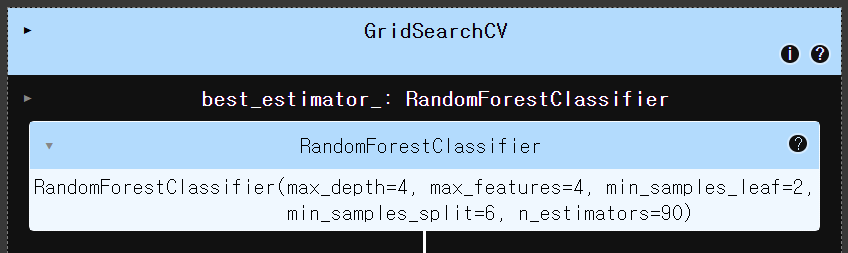

In [22]:
# 최적의 매개변수와 정확도 출력
print('best parameter:\n', clf.best_params_)
print('best prediction: {0:.4f}'.format(clf.best_score_))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:

# 테스트셋에서의 성능 확인
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy: {0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)


# 다루지 못한 요소
* 학습률, 트리 수, 트리 깊이, 조기 종료, 서브 샘플링, 변수 샘플링, 가중치 조절, 최대 리프 수, 감마
# 확장 가능한 방법
* 다중분류 문제로 바꿔보기
* 사용하는 머신러닝 알고리즘 바꿔보기
* 변수 바꿔보기
* 예측하려는 종목/자산 바꿔보기
* 노이즈 제거 방법 적용